In [22]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [19]:
X = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/X_train_J01Z4CN.csv")
y = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/y_train_OXxrJt1.csv")
y = y[["price"]] # On ne garde que la colonne price, un supprime la colonne qui porte sur le numéro de l'annonce

X.head(5)

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,299000.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,478000.0


### Etudes des colonnes à valeurs non numériques

In [4]:
s = (X.dtypes == 'object')    # pour avoir la liste des colonnes avec comme type "objet"
object_cols = list(s[s].index)

# On compte le nombre de valeurs différentes par colonne (pour après faire possiblement du One-Hot Encoding)
nb_val_col = {}
nb_val_manquantes = {}
ratio_val_manquantes = {}
for col in object_cols:
    nb_val_col[col]=[len(X[f"{col}"].value_counts())]
    nb_val_manquantes[col]=X[f"{col}"].isnull().sum() #on compte le nombre de valeurs manquantes pour savoir s'il faut garder la colonne
    ratio_val_manquantes[col]=nb_val_manquantes[col]/len(X[f"{col}"]) #on calcule le ratio de valeurs manquantes

nb_val_col_df = pd.DataFrame(nb_val_col.items(),columns = ["Nom Colonne","Nb de valeurs différentes"])
nb_val_manquantes = pd.DataFrame(nb_val_manquantes.items(),columns = ["Nom Colonne","Nb de valeurs manquantes"])
ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])

nb_val_col_df["Nb de valeurs manquantes"]=nb_val_manquantes[["Nb de valeurs manquantes"]]
nb_val_col_df['Ratio de valeurs manquantes']=ratio_val_manquantes[["Ratio de valeurs manquantes"]]

nb_val_col_df

,Nom Colonne,Nb de valeurs différentes,Nb de valeurs manquantes,Ratio de valeurs manquantes
0,property_type,[22],0,0.000000
1,city,[8643],0,0.000000
2,energy_performance_category,[7],18300,0.489724
3,ghg_category,[7],18838,0.504121
4,exposition,[12],28274,0.756637


> On décide donc de drop les colonnes energy_performance_category, ghg_category et exposition car il manque entre 49% et 76% des valeurs environ

In [20]:
X = X.drop(columns = ["energy_performance_category","ghg_category","exposition"],axis=1)
X.shape

(37368, 25)

> Pour le moment, on décide d'appliquer de l'ordinal encoding aux deux colomnes restantes à la place d'un One Hot Encoding du au nombre de valeurs différentes

In [24]:
ordinal_encoder = OrdinalEncoder()
X[["property_type","city"]] = ordinal_encoder.fit_transform(X[["property_type","city"]])
X

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
0,35996577,0.0,43.643880,7.117183,8452.0,6270,63.0,NaN,NaN,NaN,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0
1,35811033,0.0,45.695757,4.895610,8234.0,69200,90.0,3.0,NaN,223.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
2,35731841,12.0,47.966791,-1.220451,5235.0,35130,61.0,NaN,370.0,NaN,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0
3,35886765,12.0,47.289292,-1.878805,1929.0,44360,142.0,NaN,764.0,217.0,...,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,299000.0
4,35781137,0.0,45.718992,4.844234,4476.0,69007,88.0,3.0,NaN,NaN,...,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,478000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,35881571,0.0,43.480292,-1.484324,592.0,64100,2995.0,NaN,NaN,255.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
37364,35890109,0.0,48.861391,2.401158,5617.0,75020,36.0,4.0,NaN,229.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399000.0
37365,36010245,0.0,44.397837,-1.164312,827.0,40600,99.0,2.0,NaN,NaN,...,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,328000.0
37366,35864579,6.0,48.864204,2.808693,4502.0,77700,9281.0,NaN,NaN,NaN,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463000.0


### On s'occupe maintenant des valeurs nulles de toutes les colonnnes 

In [32]:
colomnes = X.columns
nb_lignes = X.shape[0]
ratio_val_manquantes = {}


for col in colomnes:
    ratio_val_manquantes[col] = X[col].isnull().sum()/nb_lignes

ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])
ratio_val_manquantes.sort_values(by = "Ratio de valeurs manquantes",ascending = False)

,Nom Colonne,Ratio de valeurs manquantes
7,floor,0.739269
8,land_size,0.583039
10,ghg_value,0.504121
9,energy_performance_value,0.489724
13,nb_bathrooms,0.355197
12,nb_bedrooms,0.073137
11,nb_rooms,0.041908
6,size,0.013702
16,nb_photos,0.000000
23,upper_floors,0.000000


> On choisit de drop les 4 colonnes où il manque le plus de données (>48% de données manquantes)

In [33]:
X = X.drop(columns = ["floor","land_size","ghg_value","energy_performance_value"],axis=1)
X.shape

(37368, 21)

> Pour les autres, on décide pour l'instant de remplacer les valeurs manquantes par une moyenne des autres

In [34]:
colomnes = X.columns

for col in colomnes:
    X[col].fillna(X[col].mean(),inplace=True)

### On regarde la corrélation entre les features (qui sont désormais toutes numériques), en ajoutant le prix

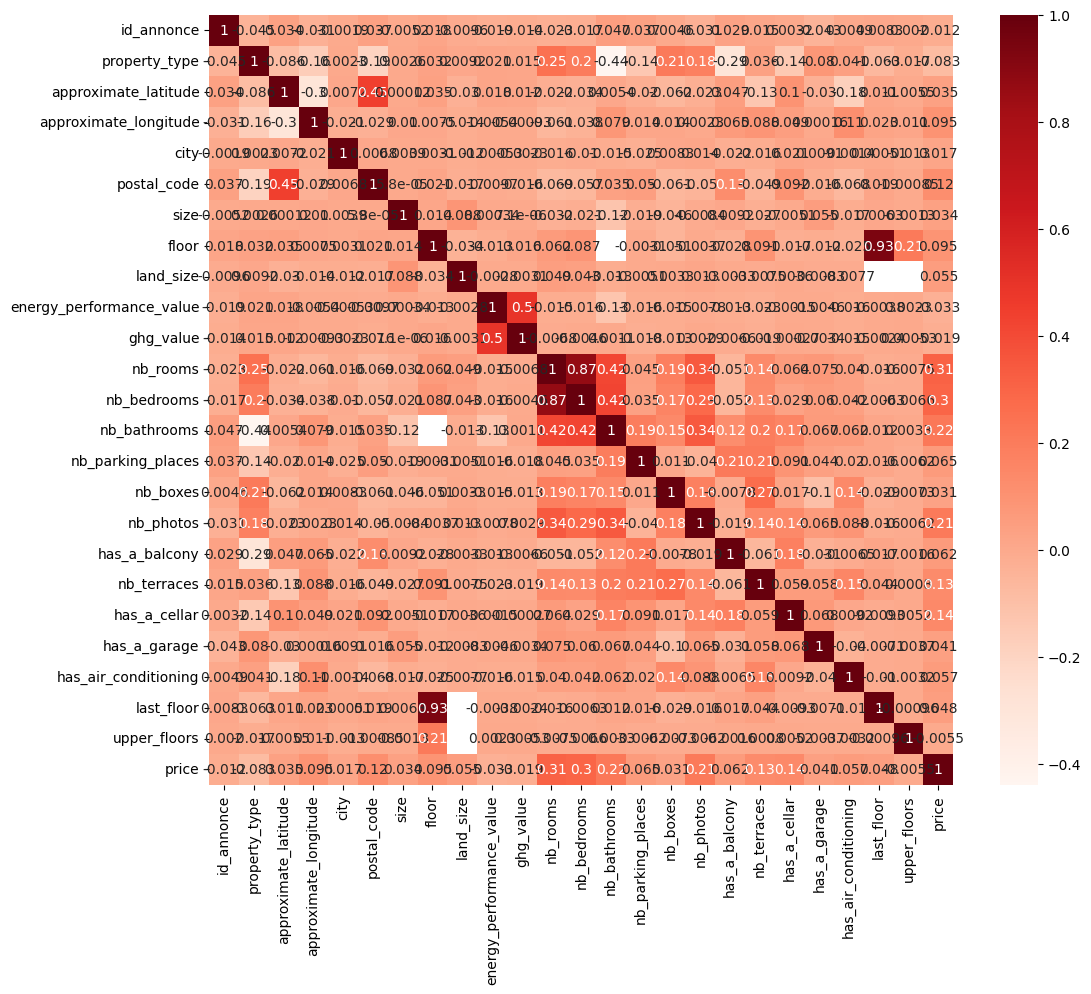

In [27]:
X_add_price = X
X_add_price["price"] = y["price"] # création d'un nouveau dataset avec les prix

plt.figure(figsize=(12,10))
cor = X_add_price.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### On regarde aussi le score de Mutual Information

In [ ]:
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

#### On regarde le nomre de valeurs différentes de property_type pour l'encoder ensuite

In [47]:
X["property_type"].value_counts()

appartement          15733
maison               15675
divers                2137
terrain               1534
villa                  781
propriété              408
terrain à bâtir        298
duplex                 220
viager                 177
ferme                  130
parking                 96
loft                    54
chalet                  48
château                 21
moulin                  17
manoir                  15
péniche                  8
hôtel particulier        6
chambre                  4
gîte                     3
atelier                  2
hôtel                    1
Name: property_type, dtype: int64

### Cluster des prix

In [44]:
# création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
X_cluster_prix = X[["approximate_latitude", "approximate_longitude"]]
X_cluster_prix["price"]=y[["price"]]

# print(X_cluster_prix.head()) 

kmeans = KMeans(n_clusters=6)
X_cluster_prix["Cluster"] = kmeans.fit_predict(X_cluster_prix)
X_cluster_prix["Cluster"] = X_cluster_prix["Cluster"].astype("category")

X_cluster_prix.head()

,approximate_latitude,approximate_longitude,price,Cluster
0,43.643880,7.117183,355000.0,5
1,45.695757,4.895610,190000.0,1
2,47.966791,-1.220451,39000.0,1
3,47.289292,-1.878805,299000.0,5
4,45.718992,4.844234,478000.0,0


#### Affichage graphique du clustering

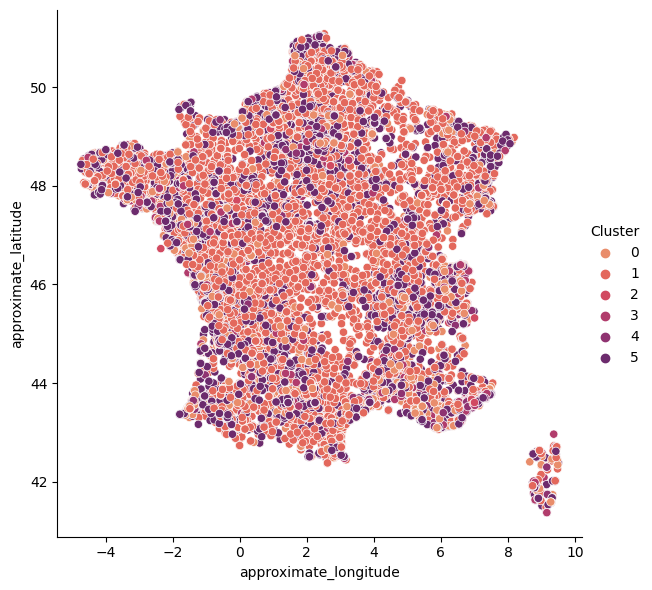

In [45]:
sns.relplot(x="approximate_longitude", y="approximate_latitude", hue = "Cluster", data=X_cluster_prix, height=6, palette = sns.color_palette("flare",n_colors = 6))